In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from collections import Counter
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from sklearn.decomposition import NMF
from gensim.models.nmf import Nmf
from operator import itemgetter
from tqdm.notebook import tqdm
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 35.4 ms


In [22]:
pd.set_option('display.max_colwidth', -1)

# Data Extraction 

In [5]:
data = pd.read_csv('hn15Feb_15Aug.csv')

In [6]:
data.shape

(8089, 11)

In [115]:
type(data['TimeGST'])

pandas.core.series.Series

time: 4.12 ms


In [24]:
data.head(1)

ID      Source                   TimeGST   TimeEpoch  Upvotes  NumComments  \
0  1   HackerNews  2020-02-29T23:57:52.000Z  1583020672  252      174           

                                                                             Title  \
0  Flutter and Dart, or how to quickly build a mobile app without losing your hair   

                                                                                              Url  \
0  https://altkomsoftware.pl/blog/flutter-dart-quickly-build-mobile-app-without-losing-much-hair/   

                                             ProcessdedTitle  \
0  flutter dart quickly build mobile app without losing hair   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          WeightedContent  \
0  flutter flutter dart vm mobile desktop device also used web development tandem alltoofamiliar angular framework aot aheadoftime compilation jit justintime hot reload f

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8089 entries, 0 to 8088
Data columns (total 11 columns):
ID                 8089 non-null int64
Source             8089 non-null object
TimeGST            8089 non-null object
TimeEpoch          8089 non-null int64
Upvotes            8089 non-null int64
NumComments        8089 non-null int64
Title              8089 non-null object
Url                8089 non-null object
ProcessdedTitle    8081 non-null object
WeightedContent    6797 non-null object
Content            7857 non-null object
dtypes: int64(4), object(7)
memory usage: 695.3+ KB


In [31]:
data.loc[data['Content'].isnull()]

,ID,Source,TimeGST,TimeEpoch,Upvotes,NumComments,Title,Url,ProcessdedTitle,WeightedContent,Content
78,84,HackerNews,2020-02-28T09:12:01.000Z,1582881121,119,81,Why did I wake up before my alarm clock went off? (2015),https://joearms.github.io/published/2015-03-02-Waking-Up.html,wake alarm clock went,NaN,NaN
143,154,HackerNews,2020-02-27T02:54:11.000Z,1582772051,554,101,The Simpsons in CSS,https://pattle.github.io/simpsons-in-css/,simpson cs,NaN,NaN
232,246,HackerNews,2020-02-25T13:34:33.000Z,1582637673,184,54,My favorite Erlang program (2013),https://joearms.github.io/published/2013-11-21-My-favorite-erlang-program.html,favorite erlang program,NaN,NaN
267,286,HackerNews,2020-02-24T13:37:51.000Z,1582551471,90,68,Trunk Road Gritter Tracker,http://scotgov.maps.arcgis.com/apps/webappviewer/index.html?id=2de764a9303848ffb9a4cac0bd0b1aab,trunk road gritter tracker,NaN,NaN
310,334,HackerNews,2020-02-23T15:23:17.000Z,1582471397,99,71,Paper Clay Air Humidifier,https://maximelouis.com/paper-clay-air-humidifier,paper clay air humidifier,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
7959,8649,HackerNews,2020-08-03T17:47:24.000Z,1596476844,130,123,Trump fires CEO of TVA over replacing US tech workers with H1B workers,https://fox17.com/news/local/trump-fires-tennessee-valley-authority-chair-citing-hiring-of-foreign-workers,trump fire ceo tva replacing u tech worker worker,NaN,NaN
7971,8662,HackerNews,2020-08-03T14:01:24.000Z,1596463284,389,84,"System UIcons – icons designed for products, no attribution",https://systemuicons.com/,system uicons icon designed product attribution,NaN,NaN
8013,8706,HackerNews,2020-08-02T15:42:14.000Z,1596382934,112,15,μPlot v1.1 – now with log scales support,https://leeoniya.github.io/uPlot/demos/log-scales.html,μplot log scale support,NaN,NaN
8015,8708,HackerNews,2020-08-02T14:44:33.000Z,1596379473,371,101,Show HN: Starboard – Fully in-browser literate notebooks like Jupyter Notebook,https://starboard.gg,show hn starboard fully inbrowser literate notebook like jupyter notebook,NaN,NaN


In [33]:
data.dropna(subset= ['Content'], inplace=True)

In [36]:
def missing_percentage(df):
    total = df.isnull().sum().sort_values(ascending = False)
    percent = round(df.isnull().sum().sort_values(ascending = False)/len(df)*100,2)
    return pd.concat([total, percent], axis=1, keys=['Total','Percent'])
missing_percentage(data)

,Total,Percent
WeightedContent,1060,13.49
ProcessdedTitle,8,0.10
Content,0,0.00
Url,0,0.00
Title,0,0.00
NumComments,0,0.00
Upvotes,0,0.00
TimeEpoch,0,0.00
TimeGST,0,0.00
Source,0,0.00


# Cleaning 

In [37]:
import spacy
spacy.load('en')
from spacy.lang.en import English
parser = English()
def tokenize(text):
    lda_tokens = []
    tokens = parser(text)
    for token in tokens:
        if token.orth_.isspace():
            continue
        elif token.like_url:
            lda_tokens.append('URL')
        elif token.orth_.startswith('@'):
            lda_tokens.append('SCREEN_NAME')
        else:
            lda_tokens.append(token.lower_)
    return lda_tokens

# Pre-processing the data for modelling 

In [38]:
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet as wn
def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma
    
from nltk.stem.wordnet import WordNetLemmatizer
def get_lemma2(word):
    return WordNetLemmatizer().lemmatize(word)

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/richachoudhary/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [39]:
nltk.download('stopwords')
en_stop = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/richachoudhary/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [40]:
def prepare_text_for_lda(text):
    tokens = tokenize(text)
    #tokens = [token for token in tokens if len(token) > 4]
    tokens = [token for token in tokens if token not in en_stop]
    tokens = [get_lemma(token) for token in tokens]
    return tokens

In [41]:
data['tokens']=  data['Content'].apply(lambda x: prepare_text_for_lda(x))

In [44]:
data.head(1)

ID      Source                   TimeGST   TimeEpoch  Upvotes  NumComments  \
0  1   HackerNews  2020-02-29T23:57:52.000Z  1583020672  252      174           

                                                                             Title  \
0  Flutter and Dart, or how to quickly build a mobile app without losing your hair   

                                                                                              Url  \
0  https://altkomsoftware.pl/blog/flutter-dart-quickly-build-mobile-app-without-losing-much-hair/   

                                             ProcessdedTitle  \
0  flutter dart quickly build mobile app without losing hair   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          WeightedContent  \
0  flutter flutter dart vm mobile desktop device also used web development tandem alltoofamiliar angular framework aot aheadoftime compilation jit justintime hot reload f

time: 26.2 ms


# EDA 

In [45]:
# Get the word count
def word_count(text):
    return len(str(text).split(' '))
data['word_count'] = data['tokens'].apply(word_count)
data['word_count'].mean()

793.2825505918289

time: 927 ms


In [48]:
data['word_count'].describe()

count    7857.000000 
mean     794.001018  
std      2273.131601 
min      1.000000    
25%      174.000000  
50%      422.000000  
75%      846.000000  
max      86592.000000
Name: word_count, dtype: float64

time: 24.1 ms


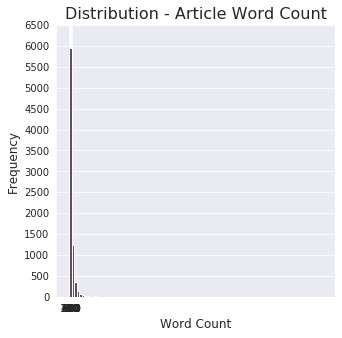

time: 440 ms


In [85]:
# Plot a hist of the word counts
fig = plt.figure(figsize=(5,5))

plt.hist(
    data['word_count'],
    bins=100,
    color='#60505C'
)

plt.title('Distribution - Article Word Count', fontsize=16)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Word Count', fontsize=12)
plt.yticks(np.arange(0, 7000, 500))
plt.xticks(np.arange(0, 1000, 100))

plt.show()

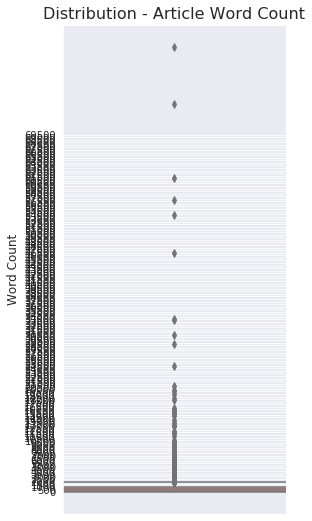

time: 1.34 s


In [93]:

# Plot a boxplot of the word counts
fig = plt.figure(figsize=(4,9))

sns.boxplot(
    data['word_count'],
    orient='v',
    width=500,
    color='#ff8080'
)

plt.ylabel("Word Count", fontsize=12)
plt.title('Distribution - Article Word Count', fontsize=16)
plt.yticks(np.arange(0, 70000, 500))

file_name = 'box_plot'

plt.show()

In [99]:

# Get the top 20 most common words among all the articles
p_text = data['tokens']

# Flaten the list of lists
p_text = [item for sublist in p_text for item in sublist]

# Top 20
top_20 = pd.DataFrame(
    Counter(p_text).most_common(2000),
    columns=['word', 'frequency']
)

top_20

,word,frequency
0,use,33573
1,one,29236
2,time,24266
3,make,23693
4,like,22438
...,...,...
1995,particle,549
1996,heap,549
1997,audience,549
1998,zone,548


time: 1.21 s


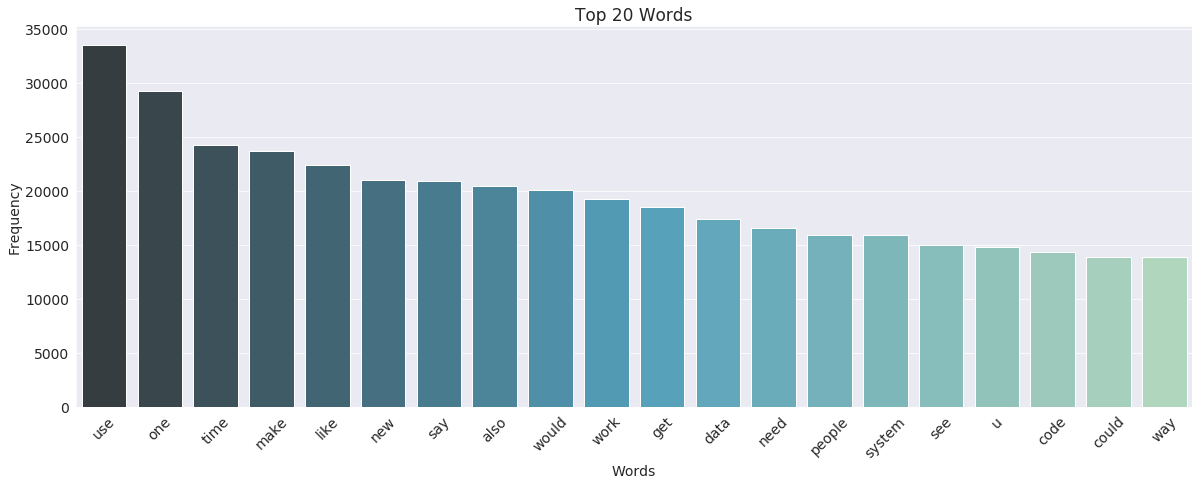

time: 733 ms


In [95]:
# Plot a bar chart for the top 20 most frequently occuring words
fig = plt.figure(figsize=(20,7))

g = sns.barplot(
    x='word',
    y='frequency',
    data=top_20,
    palette='GnBu_d'
)

g.set_xticklabels(
    g.get_xticklabels(),
    rotation=45,
    fontsize=14
)

plt.yticks(fontsize=14)
plt.xlabel('Words', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Top 20 Words', fontsize=17)

plt.show()

In [96]:
# Get the number of unique words after processing
num_unique_words = len(set(p_text))
num_unique_words

218798

time: 382 ms


In [104]:
import time 

time: 883 µs


In [108]:
#Use Gensim's NMF to get the best num of topics via coherence score
texts = data['tokens']

# Create a dictionary
# In gensim a dictionary is a mapping between words and their integer id
dictionary = Dictionary(texts)

# Filter out extremes to limit the number of features
dictionary.filter_extremes(
    no_below=3,
    no_above=0.85,
    keep_n=5000
)

# Create the bag-of-words format (list of (token_id, token_count))
corpus = [dictionary.doc2bow(text) for text in texts]

# Create a list of the topic numbers we want to try
topic_nums = list(np.arange(5, 75 + 1, 5))

# Run the nmf model and calculate the coherence score
# for each number of topics
coherence_scores = []
for i in tqdm(range(0, len(topic_nums))):
    for num in topic_nums:
        nmf = Nmf(
        corpus=corpus,
        num_topics=num,
        id2word=dictionary,
        chunksize=2000,
        passes=5,
        kappa=.1,
        minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=42
    )
    time.sleep(0.5)
    
    # Run the coherence model to get the score
    cm = CoherenceModel(
        model=nmf,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    coherence_scores.append(round(cm.get_coherence(), 5))



Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 398, in _send_bytes
    self._send(buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 397, in _send_bytes
    self._send(header)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeE

KeyboardInterrupt: 

time: 5min 20s


In [ ]:
# Get the number of topics with the highest coherence score
scores = list(zip(topic_nums, coherence_scores))
best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

# Plot the results
fig = plt.figure(figsize=(15, 7))

plt.plot(
    topic_nums,
    coherence_scores,
    linewidth=3,
    color='#4287f5'
)

plt.xlabel("Topic Num", fontsize=14)
plt.ylabel("Coherence Score", fontsize=14)
plt.title('Coherence Score by Topic Number - Best Number of Topics: {}'.format(best_num_topics), fontsize=18)
plt.xticks(np.arange(5, max(topic_nums) + 1, 5), fontsize=12)
plt.yticks(fontsize=12)

plt.show()


In [111]:
# Now use the number of topics with the 
# highest coherence score to run the 
# sklearn nmf model
from sklearn.feature_extraction.text import TfidfVectorizer


texts = data['tokens']

# Create the tfidf weights
tfidf_vectorizer = TfidfVectorizer(
    min_df=3,
    max_df=0.85,
    max_features=5000,
    ngram_range=(1, 2),
    preprocessor=' '.join
)

tfidf = tfidf_vectorizer.fit_transform(texts)

# Save the feature names for later to create topic summaries
tfidf_fn = tfidf_vectorizer.get_feature_names()

# Run the nmf model
nmf = NMF(
    n_components=8,
    init='nndsvd',
    max_iter=500,
    l1_ratio=0.0,
    solver='cd',
    alpha=0.0,
    tol=1e-4,
    random_state=42
).fit(tfidf)

time: 33.5 s


In [112]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import string
import re
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import TweetTokenizer, RegexpTokenizer
import nltk
def topic_table(model, feature_names, n_top_words):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        t = (topic_idx)
        topics[t] = [feature_names[i] for i in top_words(topic, n_top_words)]
    return pd.DataFrame(topics)

def top_words(topic, n_top_words):
    return topic.argsort()[:-n_top_words - 1:-1]  
def whitespace_tokenizer(text): 
    pattern = r"(?u)\b\w\w+\b" 
    tokenizer_regex = RegexpTokenizer(pattern)
    tokens = tokenizer_regex.tokenize(text)
    return tokens
# Funtion to remove duplicate words
def unique_words(text): 
    ulist = []
    [ulist.append(x) for x in text if x not in ulist]
    return ulist
# Use the top words for each cluster by tfidf weight
# to create 'topics'

# Getting a df with each topic by document
docweights = nmf.transform(tfidf_vectorizer.transform(texts))

n_top_words = 8

topic_df = topic_table(
    nmf,
    tfidf_fn,
    n_top_words
).T

# Cleaning up the top words to create topic summaries
topic_df['topics'] = topic_df.apply(lambda x: [' '.join(x)], axis=1) # Joining each word into a list
topic_df['topics'] = topic_df['topics'].str[0]  # Removing the list brackets
topic_df['topics'] = topic_df['topics'].apply(lambda x: whitespace_tokenizer(x)) # tokenize
topic_df['topics'] = topic_df['topics'].apply(lambda x: unique_words(x))  # Removing duplicate words
topic_df['topics'] = topic_df['topics'].apply(lambda x: [' '.join(x)])  # Joining each word into a list
topic_df['topics'] = topic_df['topics'].str[0]  # Removing the list brackets

topic_df.head()

,0,1,2,3,4,5,6,7,topics
0,say,people,company,one,would,year,time,make,say people company one would year time make
1,network continue,please click,computer network,robot,let know,unusual,click,box,network continue please click computer robot let know unusual box
2,proceed,disabled,legacy,would like,javascript,browser,twitter,detect,proceed disabled legacy would like javascript browser twitter detect
3,use,code,file,data,user,system,using,nt,use code file data user system using nt
4,obj,endobj,endobj obj,stream,obj stream,endstream,endstream endobj,obj endobj,obj endobj stream endstream


time: 12.6 s
